In [60]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [61]:
start = "2000-01-01"
end = datetime.datetime.today().strftime("%Y-%m-%d")

ticker = "^GSPC"

data = yf.download(ticker, start=start, end=end)

print(data.head())

C:\Users\cauch\AppData\Local\Temp\ipykernel_2596\2510294644.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   931800000
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1009000000
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1085500000
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1092300000
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1225200000


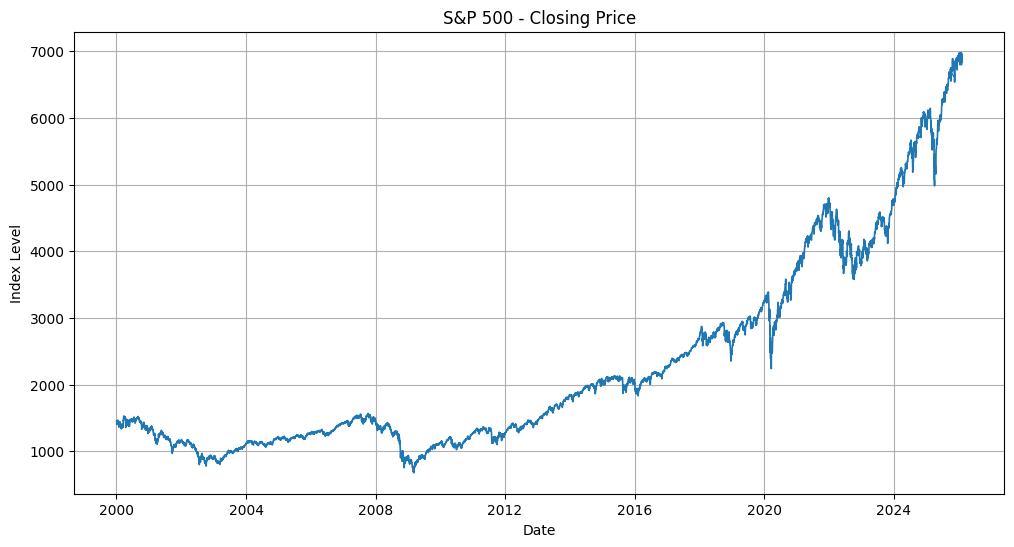

In [62]:
# Création du graphique
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], linewidth=1.2)

plt.title("S&P 500 - Closing Price")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)

plt.show()

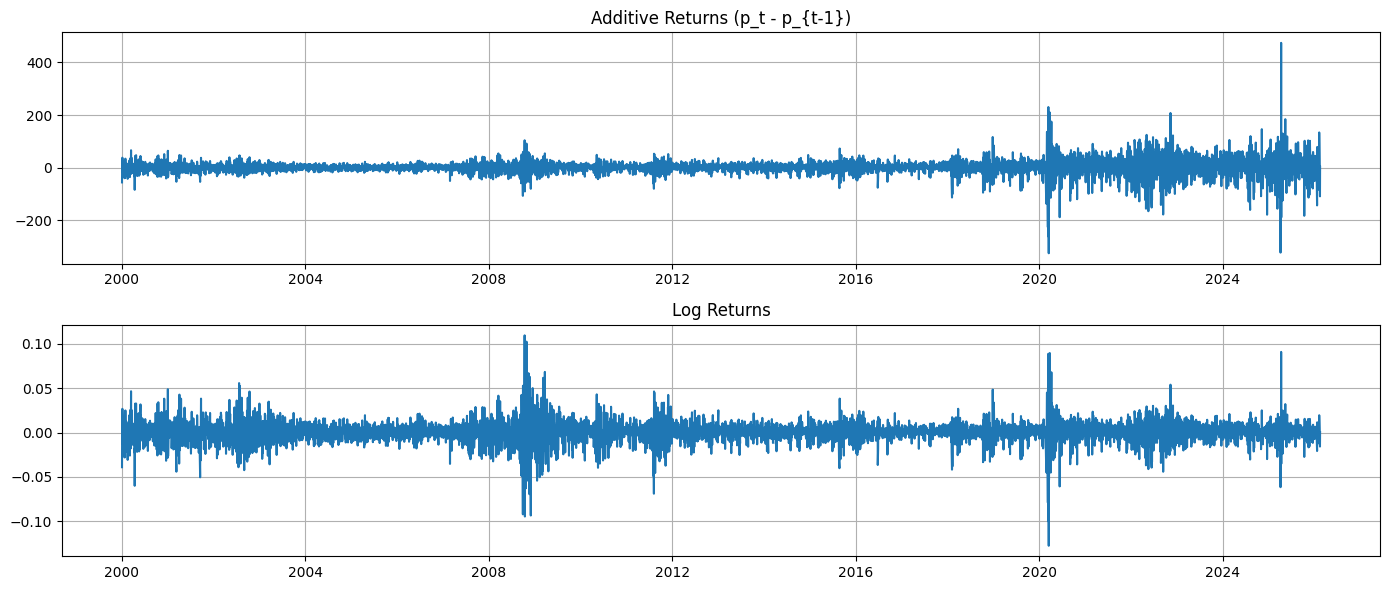

In [63]:
data["a_returns"] = data["Close"] - data["Close"].shift(1)
data["l_returns_1"] = np.log(data["Close"]/data["Close"].shift(1))
data = data.dropna()

plt.figure(figsize=(14,6))

plt.subplot(2,1,1)
plt.plot(data.index, data["a_returns"])
plt.title("Additive Returns (p_t - p_{t-1})")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(data.index, data["l_returns_1"])
plt.title("Log Returns")
plt.grid(True)

plt.tight_layout()
plt.show()

log returns : $r_t = \text{log} \left( \frac{p_t}{p_{t-1}} \right) = \text{log} \left( 1 + \frac{p_t-p_{t-1}}{p_{t-1}} \right)$

additive returns : $r_t = p_t - p_{t-1}$

We notice that log returns are more stable than additive returns.

Variogram : $V(\tau) = \left\langle \log \left( \frac{p_t}{p_{t-\tau}} \right)^2 \right\rangle$

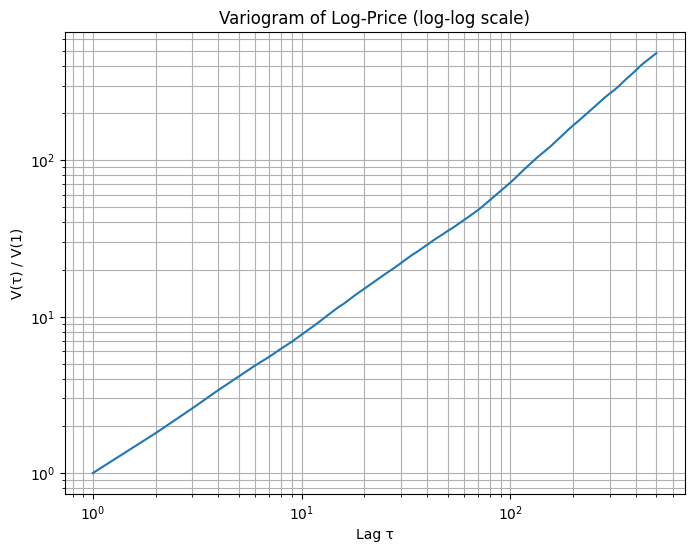

In [64]:
V = []
max_lags = 500
p = data["Close"].values
logp = np.log(p)
for tau in range(1, max_lags+1):
    diffs = logp[tau:] - logp[:-tau]
    V.append(np.mean(diffs**2))

V_normalized = V / V[0]
taus = np.arange(1, max_lags+1)

plt.figure(figsize=(8,6))
plt.loglog(taus, V_normalized)
plt.xlabel("Lag τ")
plt.ylabel("V(τ) / V(1)")
plt.title("Variogram of Log-Price (log-log scale)")
plt.grid(True, which="both")
plt.show()

In [65]:
def r_scale(delta):
    return (np.log(data["Close"]) - np.log(data["Close"].shift(delta))).dropna()

r1 = r_scale(1)
r250 = r_scale(250)

print(r1.mean().iloc[0] * 250, r1.std().iloc[0] * np.sqrt(250))
print(r250.mean().iloc[0], r250.std().iloc[0])

0.060384107103342466 0.19273240178854725
0.058810667498227547 0.169638469839719


6567


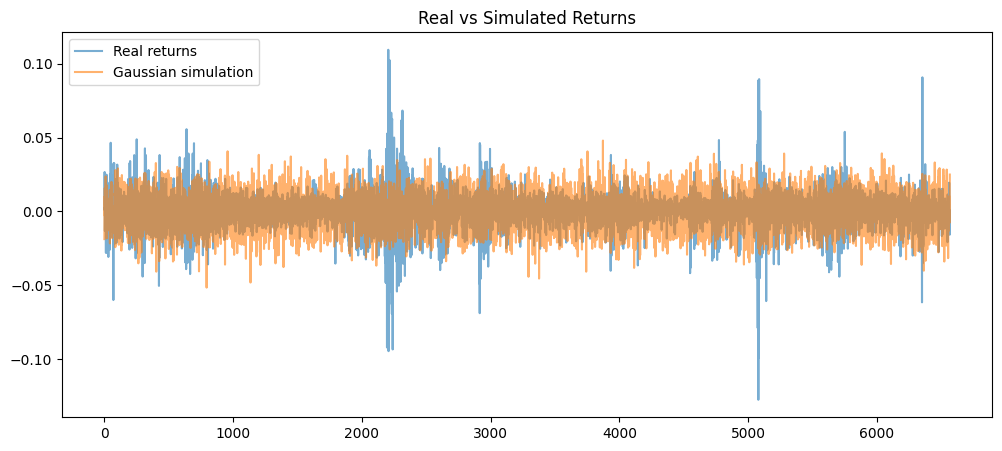

In [66]:
n = len(r1)
print(n)
eta = np.random.randn(n)
sigma = r1.std().iloc[0]
r_tilde = sigma * eta

plt.figure(figsize=(12,5))

plt.plot(r1.values, label="Real returns", alpha=0.6)
plt.plot(r_tilde, label="Gaussian simulation", alpha=0.6)

plt.legend()
plt.title("Real vs Simulated Returns")
plt.show()


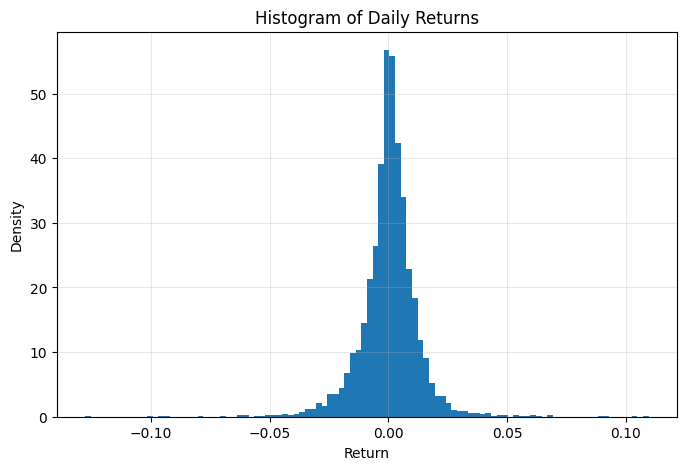

In [67]:
plt.figure(figsize=(8,5))
plt.hist(r1, bins=100, density=True)
plt.title("Histogram of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()


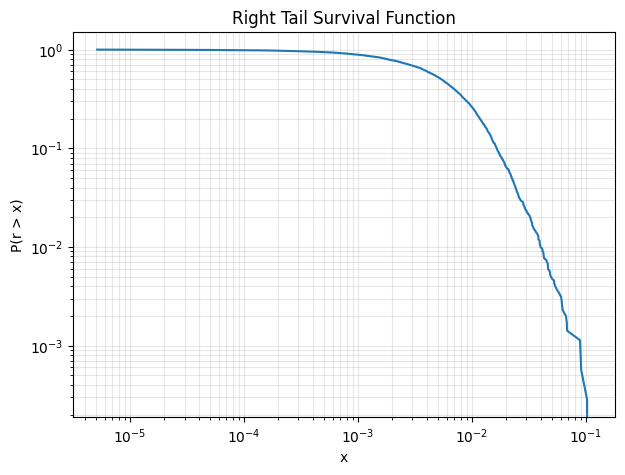

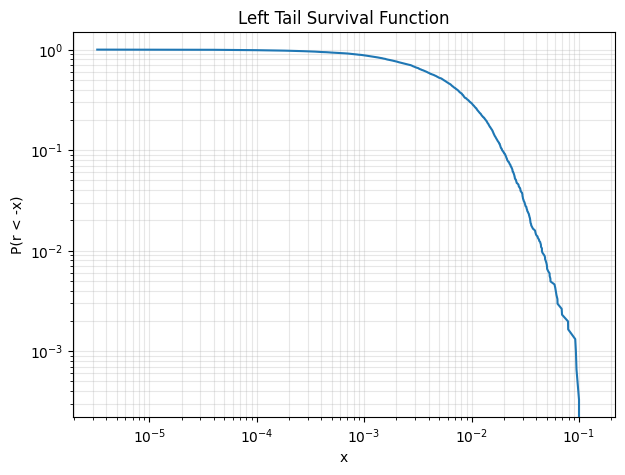

In [68]:
# Récupérer les rendements
r = r1.values

# -----------------------
# Queue droite : P(r > x)
# -----------------------
r_pos = np.sort(r[r > 0])
N_pos = len(r_pos)
F_pos = 1 - np.arange(1, N_pos+1)/N_pos

plt.figure(figsize=(7,5))
plt.loglog(r_pos, F_pos)
plt.xlabel("x")
plt.ylabel("P(r > x)")
plt.title("Right Tail Survival Function")
plt.grid(True, which="both", alpha=0.3)
plt.show()


# -----------------------
# Queue gauche : P(r < -x)
# -----------------------
r_neg = np.sort(-r[r < 0])   # on prend -r pour avoir des valeurs positives
N_neg = len(r_neg)
F_neg = 1 - np.arange(1, N_neg+1)/N_neg

plt.figure(figsize=(7,5))
plt.loglog(r_neg, F_neg)
plt.xlabel("x")
plt.ylabel("P(r < -x)")
plt.title("Left Tail Survival Function")
plt.grid(True, which="both", alpha=0.3)
plt.show()


# Correlations

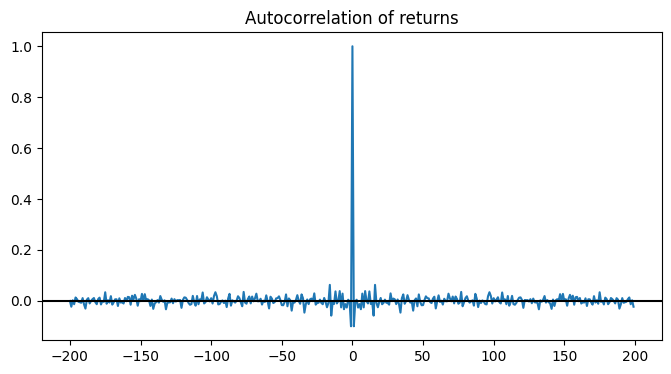

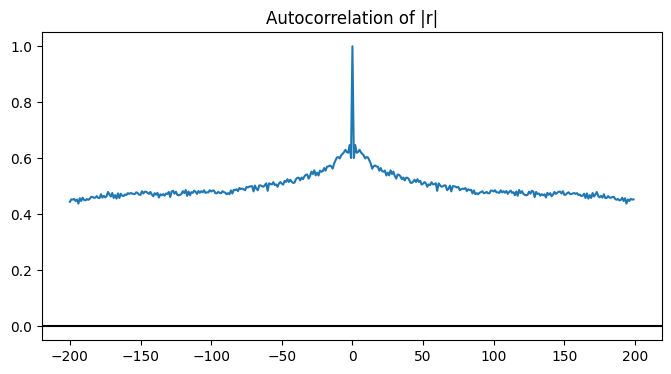

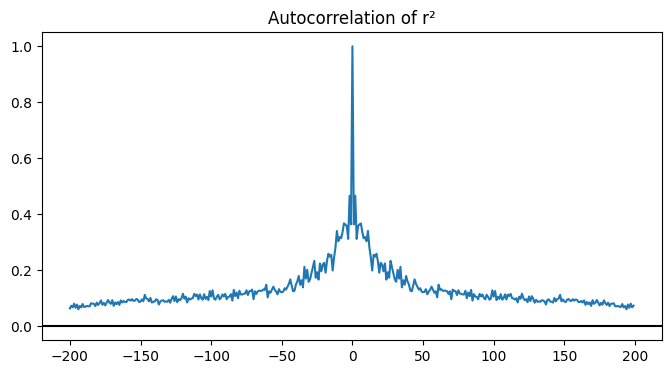

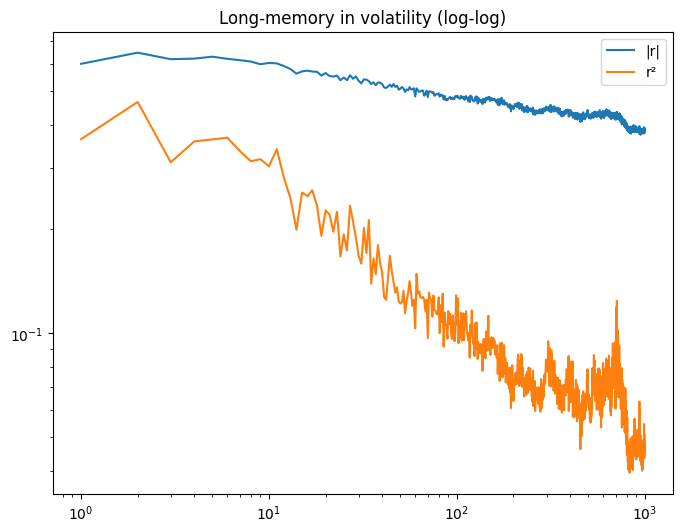

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Centrer les rendements
# =========================

r = r1.values
r = r - np.mean(r)

# =========================
# 2. Fonction autocorrélation
# =========================

def autocorr(x, max_lag):
    T = len(x)
    acf = []
    var = np.mean(x**2)
    
    for tau in range(-max_lag, max_lag):
        if tau >= 0:
            num = np.mean(x[:T-tau] * x[tau:])
        else:
            num = np.mean(x[-tau:] * x[:T+tau])
        acf.append(num / var)
    
    return np.array(acf)

# =========================
# 3. Autocorrélation rendements
# =========================

max_lag = 200
C_rr = autocorr(r, max_lag)

lags = np.arange(-max_lag, max_lag)

plt.figure(figsize=(8,4))
plt.plot(lags, C_rr)
plt.title("Autocorrelation of returns")
plt.axhline(0, color='black')
plt.show()

# =========================
# 4. Autocorrélation |r|
# =========================

r_abs = np.abs(r)
C_abs = autocorr(r_abs, 200)

plt.figure(figsize=(8,4))
plt.plot(lags, C_abs)
plt.title("Autocorrelation of |r|")
plt.axhline(0, color='black')
plt.show()

# =========================
# 5. Autocorrélation r²
# =========================

r2 = r**2
C_r2 = autocorr(r2, 200)

plt.figure(figsize=(8,4))
plt.plot(lags, C_r2)
plt.title("Autocorrelation of r²")
plt.axhline(0, color='black')
plt.show()

# =========================
# 6. Long lags log-log
# =========================

max_lag_long = 1000
lags_pos = np.arange(1, max_lag_long)

def autocorr_pos(x, max_lag):
    T = len(x)
    var = np.mean(x**2)
    acf = []
    for tau in range(1, max_lag):
        num = np.mean(x[:T-tau] * x[tau:])
        acf.append(num / var)
    return np.array(acf)

C_abs_long = autocorr_pos(r_abs, max_lag_long)
C_r2_long = autocorr_pos(r2, max_lag_long)

plt.figure(figsize=(8,6))
plt.loglog(lags_pos, C_abs_long, label="|r|")
plt.loglog(lags_pos, C_r2_long, label="r²")
plt.legend()
plt.title("Long-memory in volatility (log-log)")
plt.show()


Leverage effect

# Préparation
r = r1.values
r = r - np.mean(r)
T = len(r)

def leverage_corr(r, max_lag):
    L = []
    for tau in range(1, max_lag+1):
        corr = np.corrcoef(r[tau:]**2, r[:-tau])[0,1]
        L.append(corr)
    return np.array(L)

max_lag = 200
lags = np.arange(1, max_lag+1)
L_tau = leverage_corr(r, max_lag)

plt.figure(figsize=(8,5))
plt.plot(lags, L_tau)
plt.axhline(0, color='black')
plt.xlabel("τ")
plt.ylabel("Corr(r²_{t+τ}, r_t)")
plt.title("Leverage Effect")
plt.grid(alpha=0.3)
plt.show()
